# Setup

In [1]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from experiments.irl.datasets import *
from experiments.irl.experiment_utils import *
from research.irl.fair_irl import *
from research.utils import *
from sklearn.model_selection import train_test_split


logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

from IPython.display import display, HTML
display(HTML("<style>.container { width:1800px !important; }</style>"))
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

# Experiment Parameters

In [2]:
results = []

In [3]:
base_exp_info = {
    'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'],
    # Expert demo parameters
    'DATASET': None,
    'TARGET_DATASET': None,
    'N_EXPERT_DEMOS': 3,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 250_000,
    # IRL Loop parameters
    'N_TRIALS': 1,
    'IRL_METHOD': None,
    'MIN_FREQ_FILL_PCT': .1,
    'EPSILON': .01,
    'MAX_ITER': 5,
    'METHOD': 'highs',
    'IRL_ERROR_NORM_WEIGHTS': False,
    # Plotting parameters
    'NOISE_FACTOR': .02,
    'ANNOTATE': True,
    
    'IRL_METHOD': 'FairIRL',
    'N_INIT_POLICIES': 3,
    'NON_EXPERT_ALGOS': [
        'DummyNoisy',
        'DummyNoisy',
        'Dummy',
    ],

}

In [34]:
experiments = [
    # AL -> CA
    {
        'DATASET': 'ACSIncome__AL',
        'TARGET_DATASET': 'ACSIncome__CA',
        'EXPERT_ALGO': 'OptAcc',
    },
    {
        'DATASET': 'ACSIncome__AL',
        'TARGET_DATASET': 'ACSIncome__CA',
        'EXPERT_ALGO': 'HardtDemPar',
    },
    {
        'DATASET': 'ACSIncome__AL',
        'TARGET_DATASET': 'ACSIncome__CA',
        'EXPERT_ALGO': 'HardtEqOpp',
    },
    # CA -> AL
    {
        'DATASET': 'ACSIncome__CA',
        'TARGET_DATASET': 'ACSIncome__AL',
        'EXPERT_ALGO': 'OptAcc',
    },
    {
        'DATASET': 'ACSIncome__CA',
        'TARGET_DATASET': 'ACSIncome__AL',
        'EXPERT_ALGO': 'HardtDemPar',
    },
    {
        'DATASET': 'ACSIncome__CA',
        'TARGET_DATASET': 'ACSIncome__AL',
        'EXPERT_ALGO': 'HardtEqOpp',
    },
]

experiments *= 1

# Load train/test data

In [ ]:
for exp_i, experiment in enumerate(experiments):
    print(f"Starting experiment {exp_i+1}/{len(experiments)}")
    
    exp_info = dict(base_exp_info)
    for k in experiment:
        exp_info[k] = experiment[k]
    display(exp_info)

    objectives = []
    for obj_name in exp_info['OBJECTIVE_NAMES']:
        objectives.append(OBJ_LOOKUP_BY_NAME[obj_name]())
    obj_set = ObjectiveSet(objectives)
    del objectives

    #############
    # LOAD DATA #
    #############

    from sklearn.model_selection import train_test_split

    # Load train data (source domain)
    X_source, y_source, feature_types = generate_dataset(
        exp_info['DATASET'],
        n_samples=exp_info['N_DATASET_SAMPLES'],
    )

    # Load test data (target domain)
    X_target, y_target, _ = generate_dataset(
        exp_info['TARGET_DATASET'],
        n_samples=exp_info['N_DATASET_SAMPLES'],
    )

    X_target_train, X_target_test, y_target_train, y_target_test = train_test_split(
        X_target, y_target, test_size=.25)
    del X_target, y_target


    ################
    # TRAIN MODELS #
    ################


    # Using FairIRL
    # Learn weights from source train. Build classifier on target train.
    # Predict on target test.
    ####################################################################


    # Learn weights using source domain train set
    _, _, _, weights, t_hold = run_trial_source_domain(
        exp_info,
        X=X_source,
        y=y_source,
        feature_types=feature_types,
    )

    # Compute optimal classifier on target domain train set
    _, _, clf_pol = run_trial_target_domain(
        exp_info,
        weights,
        t_hold,
        X=X_target_train,
        y=y_target_train,
        feature_types=feature_types,
    )

    # Predict on target domain test set
    df_test = pd.DataFrame(X_target_test)
    df_test['yhat'] = clf_pol.predict(df_test).astype(int)
    df_test['y'] = y_target_test
    # Show the learned policy prediction rates as a gut check
    display(df_test.groupby(['z'])[['yhat']].agg(['count', 'mean']))
    feature_exp = obj_set.compute_demo_feature_exp(df_test)

    # Persist results
    result = {}
    result['METHOD'] = 'FairIRL'
    result['EXPERT_ALGO'] = exp_info['EXPERT_ALGO']
    for i, obj_name in enumerate(exp_info['OBJECTIVE_NAMES']):
        result = dict(result)
        result['METRIC_NAME'] = obj_name
        result['METRIC_VALUE'] = feature_exp[i]
        result['DATASET'] = exp_info['DATASET']
        result['TARGET_DATASET'] = exp_info['TARGET_DATASET']
        results.append(result)
        display(result)


    # Using model trained on source
    # Train model on source train. Predict on target test.
    ######################################################
    expert_algo_lookup = generate_expert_algo_lookup(feature_types)
    expert_algo = expert_algo_lookup[exp_info['EXPERT_ALGO']]
    # Fit classifier on source train set
    expert_algo.fit(X_source, y_source)
    # Predict on target domain test set
    df_test = pd.DataFrame(X_target_test)
    df_test['yhat'] = expert_algo.predict(df_test).astype(int)
    df_test['y'] = y_target_test
    # Show the learned policy prediction rates as a gut check
    display(df_test.groupby(['z'])[['yhat']].agg(['count', 'mean']))
    feature_exp = obj_set.compute_demo_feature_exp(df_test)
    del expert_algo


    # Persist results
    result = {}
    result['METHOD'] = 'SourceClassifier'
    result['EXPERT_ALGO'] = exp_info['EXPERT_ALGO']
    for i, obj_name in enumerate(exp_info['OBJECTIVE_NAMES']):
        result = dict(result)
        result['METRIC_NAME'] = obj_name
        result['METRIC_VALUE'] = feature_exp[i]
        result['DATASET'] = exp_info['DATASET']
        result['TARGET_DATASET'] = exp_info['TARGET_DATASET']
        results.append(result)
        display(result)


    # Compare against threshold optimzer trained directly on test domain
    # Train model on target train. Predict on target test.
    ####################################################################
    expert_algo_lookup = generate_expert_algo_lookup(feature_types)
    expert_algo = expert_algo_lookup[exp_info['EXPERT_ALGO']]
    # Fit classifier on target domain train set
    expert_algo.fit(X_target_train, y_target_train)
    # Predict on target domain test set
    df_hold = pd.DataFrame(X_target_test)
    df_hold['yhat'] = expert_algo.predict(df_hold).astype(int)
    df_hold['y'] = y_target_test
    # Show the learned policy prediction rates as a gut check
    display(df_hold.groupby(['z'])[['yhat']].agg(['count', 'mean']))
    feature_exp = obj_set.compute_demo_feature_exp(df_hold)
    del expert_algo

    # Persist results
    #################
    result = {}
    result['METHOD'] = 'ClassifierTrainedOnTest'
    result['EXPERT_ALGO'] = exp_info['EXPERT_ALGO']
    for i, obj_name in enumerate(exp_info['OBJECTIVE_NAMES']):
        result = dict(result)
        result['METRIC_NAME'] = obj_name
        result['METRIC_VALUE'] = feature_exp[i]
        result['DATASET'] = exp_info['DATASET']
        result['TARGET_DATASET'] = exp_info['TARGET_DATASET']
        results.append(result)
        display(result)

Starting experiment 1/6


{'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'],
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA',
 'N_EXPERT_DEMOS': 3,
 'EXPERT_ALGO': 'OptAcc',
 'N_DATASET_SAMPLES': 250000,
 'N_TRIALS': 1,
 'IRL_METHOD': 'FairIRL',
 'MIN_FREQ_FILL_PCT': 0.1,
 'EPSILON': 0.01,
 'MAX_ITER': 5,
 'METHOD': 'highs',
 'IRL_ERROR_NORM_WEIGHTS': False,
 'NOISE_FACTOR': 0.02,
 'ANNOTATE': True,
 'N_INIT_POLICIES': 3,
 'NON_EXPERT_ALGOS': ['DummyNoisy', 'DummyNoisy', 'Dummy']}

INFO:root:muE:
[[0.74386512 0.89303589 0.89356189]
 [0.74562746 0.87675235 0.8568734 ]
 [0.74808748 0.88176446 0.86536897]]
INFO:root:muE_hold:
[[0.74068519 0.86960379 0.8773746 ]
 [0.74560509 0.88602132 0.87998378]
 [0.74558982 0.88734479 0.8561974 ]]
INFO:root:muL:
[[0.49354545 0.82286159 0.81145616]
 [0.4919697  0.81227324 0.83159553]
 [0.49542424 0.89723097 0.90248301]]
INFO:root:	IRL Loop iteration 1/5 ...


(<scipy.optimize._constraints.LinearConstraint at 0x11e5cc670>,
 {'type': 'ineq',
  'fun': <function research.ml.svm.SVM.fit.<locals>.<lambda>(a)>},
 <scipy.optimize._constraints.LinearConstraint at 0x11e5cdb40>)

INFO:root:		 muL[0] = [0.75  0.882 0.881]
INFO:root:		 mu_delta[0] 	= [-0.004  0.002 -0.009]
INFO:root:		 t[0] 		= 0.00368
INFO:root:		 weights[0] 	= [0.988 0.012 0.   ]
INFO:root:Best Learned Policy yhat: 0.275
INFO:root:best weight:	 [0.988 0.012 0.   ]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.744,0.893,0.894,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.0,inf,inf,0.0,0.0
1,0.746,0.877,0.857,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.0,inf,inf,0.0,0.0
2,0.748,0.882,0.865,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.0,inf,inf,0.0,0.0
3,0.494,0.823,0.811,0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.0,inf,inf,0.0,0.0
4,0.492,0.812,0.832,0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.0,inf,inf,0.0,0.0
5,0.495,0.897,0.902,0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.0,inf,inf,0.0,0.0
6,0.750,0.882,0.881,0,0.75,0.747,0.747,0.882,0.885,0.885,0.881,0.887,0.887,0.0,3.0,0.988,0.012,0.0,0.004,0.003,0.0,0.0


INFO:root:muE_target:
[[0.684352   0.96810899 0.97020505]
 [0.687296   0.97110674 0.9704581 ]
 [0.687104   0.97181982 0.98558242]]
INFO:root:target domain muL = [0.688 0.961 0.965]
INFO:root:target domain muE = [0.686 0.97  0.975]
INFO:root:target domain muL_hold = [0.686 0.965 0.974]


yhat          
   count      mean
z                 
0  24098  0.452278
1  38402  0.479038

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.687664,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.9732406472331794,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.994111578963832,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

yhat          
   count      mean
z                 
0  24098  0.256411
1  38402  0.261705

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.668176,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.9947062009165057,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.9915241575456863,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

yhat          
   count      mean
z                 
0  24098  0.436758
1  38402  0.462398

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.68992,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.9743604454164296,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.9940803808276356,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

Starting experiment 2/6


{'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'],
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA',
 'N_EXPERT_DEMOS': 3,
 'EXPERT_ALGO': 'HardtDemPar',
 'N_DATASET_SAMPLES': 250000,
 'N_TRIALS': 1,
 'IRL_METHOD': 'FairIRL',
 'MIN_FREQ_FILL_PCT': 0.1,
 'EPSILON': 0.01,
 'MAX_ITER': 5,
 'METHOD': 'highs',
 'IRL_ERROR_NORM_WEIGHTS': False,
 'NOISE_FACTOR': 0.02,
 'ANNOTATE': True,
 'N_INIT_POLICIES': 3,
 'NON_EXPERT_ALGOS': ['DummyNoisy', 'DummyNoisy', 'Dummy']}

INFO:root:muE:
[[0.71227575 0.99894382 0.93156175]
 [0.7103771  0.99947953 0.92716717]
 [0.71487715 0.99316296 0.90456295]]
INFO:root:muE_hold:
[[0.71356573 0.99074333 0.9248833 ]
 [0.71326573 0.99943606 0.93243221]
 [0.70934837 0.99166681 0.93867884]]
INFO:root:muL:
[[0.49036364 0.81418334 0.80668304]
 [0.49406061 0.81205519 0.79876617]
 [0.4989697  0.91791017 0.89973377]]
INFO:root:	IRL Loop iteration 1/5 ...


(<scipy.optimize._constraints.LinearConstraint at 0x11e622230>,
 {'type': 'ineq',
  'fun': <function research.ml.svm.SVM.fit.<locals>.<lambda>(a)>},
 <scipy.optimize._constraints.LinearConstraint at 0x164d89e10>)

INFO:root:		 muL[0] = [0.748 0.884 0.875]
INFO:root:		 mu_delta[0] 	= [-0.036  0.113  0.046]
INFO:root:		 t[0] 		= 0.03788
INFO:root:		 weights[0] 	= [0.681 0.254 0.065]
INFO:root:	IRL Loop iteration 2/5 ...


(<scipy.optimize._constraints.LinearConstraint at 0x11e5cf940>,
 {'type': 'ineq',
  'fun': <function research.ml.svm.SVM.fit.<locals>.<lambda>(a)>},
 <scipy.optimize._constraints.LinearConstraint at 0x164d8ae30>)

INFO:root:		 muL[1] = [0.731 0.999 0.989]
INFO:root:		 mu_delta[1] 	= [-0.018 -0.002 -0.068]
INFO:root:		 t[1] 		= 0.01194
INFO:root:		 weights[1] 	= [0.113 0.716 0.171]
INFO:root:	IRL Loop iteration 3/5 ...


(<scipy.optimize._constraints.LinearConstraint at 0x164d8a110>,
 {'type': 'ineq',
  'fun': <function research.ml.svm.SVM.fit.<locals>.<lambda>(a)>},
 <scipy.optimize._constraints.LinearConstraint at 0x164d88130>)

INFO:root:		 muL[2] = [0.731 0.999 0.987]
INFO:root:		 mu_delta[2] 	= [-0.018 -0.002 -0.068]
INFO:root:		 t[2] 		= 0.00179
INFO:root:		 weights[2] 	= [0.036 0.964 0.   ]
INFO:root:Best Learned Policy yhat: 0.299
INFO:root:best weight:	 [0.036 0.964 0.   ]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.712,0.999,0.932,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.710,0.999,0.927,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.715,0.993,0.905,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.490,0.814,0.807,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.494,0.812,0.799,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.499,0.918,0.900,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.748,0.884,0.875,0,0.748,0.750,0.750,0.884,0.887,0.887,0.875,0.872,0.872,0.0,3.0,0.681,0.254,0.065,0.038,0.038,0.0,0.0
7,0.731,0.999,0.989,0,0.731,0.733,0.733,0.999,0.997,0.997,0.989,0.987,0.987,0.0,4.0,0.113,0.716,0.171,0.012,0.010,0.0,0.0
8,0.731,0.999,0.987,0,0.731,0.732,0.733,0.999,0.999,0.997,0.989,0.980,0.987,0.0,5.0,0.036,0.964,0.000,0.002,0.003,0.0,0.0


INFO:root:muE_target:
[[0.680128   0.99308468 0.96875948]
 [0.674816   0.99515502 0.98726754]
 [0.655616   0.99417502 0.96770895]]
INFO:root:target domain muL = [0.682 0.999 0.992]
INFO:root:target domain muE = [0.67  0.994 0.975]
INFO:root:target domain muL_hold = [0.682 0.999 0.992]


yhat          
   count      mean
z                 
0  23792  0.460827
1  38708  0.461067

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'HardtDemPar',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.682736,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'HardtDemPar',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.9997596892054518,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'HardtDemPar',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.987369003788608,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

yhat          
   count      mean
z                 
0  23792  0.278917
1  38708  0.176165

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'HardtDemPar',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.639856,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'HardtDemPar',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.897247850702089,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'HardtDemPar',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.8315232630588747,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

yhat          
   count      mean
z                 
0  23792  0.370335
1  38708  0.368063

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'HardtDemPar',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.674528,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'HardtDemPar',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.9977288831753882,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'HardtDemPar',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.9673344381114644,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

Starting experiment 3/6


{'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'],
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA',
 'N_EXPERT_DEMOS': 3,
 'EXPERT_ALGO': 'HardtEqOpp',
 'N_DATASET_SAMPLES': 250000,
 'N_TRIALS': 1,
 'IRL_METHOD': 'FairIRL',
 'MIN_FREQ_FILL_PCT': 0.1,
 'EPSILON': 0.01,
 'MAX_ITER': 5,
 'METHOD': 'highs',
 'IRL_ERROR_NORM_WEIGHTS': False,
 'NOISE_FACTOR': 0.02,
 'ANNOTATE': True,
 'N_INIT_POLICIES': 3,
 'NON_EXPERT_ALGOS': ['DummyNoisy', 'DummyNoisy', 'Dummy']}

INFO:root:muE:
[[0.71866563 0.95022571 0.99048825]
 [0.71781718 0.94239947 0.98275184]
 [0.72123721 0.94877921 0.99871285]]
INFO:root:muE_hold:
[[0.71854563 0.94747347 0.99935858]
 [0.71662567 0.95683768 0.99818712]
 [0.71774871 0.9596153  0.99132417]]
INFO:root:muL:
[[0.49469697 0.81626667 0.81406553]
 [0.49569697 0.81635096 0.7963608 ]
 [0.49718182 0.89383593 0.89906376]]
INFO:root:	IRL Loop iteration 1/5 ...


(<scipy.optimize._constraints.LinearConstraint at 0x164d88a90>,
 {'type': 'ineq',
  'fun': <function research.ml.svm.SVM.fit.<locals>.<lambda>(a)>},
 <scipy.optimize._constraints.LinearConstraint at 0x164d89c00>)

INFO:root:		 muL[0] = [0.747 0.878 0.862]
INFO:root:		 mu_delta[0] 	= [-0.028  0.069  0.129]
INFO:root:		 t[0] 		= 0.03634
INFO:root:		 weights[0] 	= [0.625 0.138 0.237]
INFO:root:	IRL Loop iteration 2/5 ...


(<scipy.optimize._constraints.LinearConstraint at 0x1616315a0>,
 {'type': 'ineq',
  'fun': <function research.ml.svm.SVM.fit.<locals>.<lambda>(a)>},
 <scipy.optimize._constraints.LinearConstraint at 0x164d8b130>)

INFO:root:		 muL[1] = [0.731 0.985 0.967]
INFO:root:		 mu_delta[1] 	= [-0.011 -0.038  0.024]
INFO:root:		 t[1] 		= 0.01835
INFO:root:		 weights[1] 	= [0.106 0.313 0.581]
INFO:root:	IRL Loop iteration 3/5 ...


(<scipy.optimize._constraints.LinearConstraint at 0x16185feb0>,
 {'type': 'ineq',
  'fun': <function research.ml.svm.SVM.fit.<locals>.<lambda>(a)>},
 <scipy.optimize._constraints.LinearConstraint at 0x11e5ce620>)

INFO:root:		 muL[2] = [0.747 0.878 0.861]
INFO:root:		 mu_delta[2] 	= [-0.011 -0.038  0.024]
INFO:root:		 t[2] 		= 0.02196
INFO:root:		 weights[2] 	= [0.082 0.    0.918]
INFO:root:	IRL Loop iteration 4/5 ...


(<scipy.optimize._constraints.LinearConstraint at 0x16185dfc0>,
 {'type': 'ineq',
  'fun': <function research.ml.svm.SVM.fit.<locals>.<lambda>(a)>},
 <scipy.optimize._constraints.LinearConstraint at 0x164d89420>)

INFO:root:		 muL[3] = [0.747 0.879 0.861]
INFO:root:		 mu_delta[3] 	= [-0.011 -0.038  0.024]
INFO:root:		 t[3] 		= 0.02197
INFO:root:		 weights[3] 	= [0.081 0.    0.919]
INFO:root:	IRL Loop iteration 5/5 ...


(<scipy.optimize._constraints.LinearConstraint at 0x11e5cfa30>,
 {'type': 'ineq',
  'fun': <function research.ml.svm.SVM.fit.<locals>.<lambda>(a)>},
 <scipy.optimize._constraints.LinearConstraint at 0x11e5cc9d0>)

INFO:root:		 muL[4] = [0.747 0.878 0.861]
INFO:root:		 mu_delta[4] 	= [-0.011 -0.038  0.024]
INFO:root:		 t[4] 		= 0.02198
INFO:root:		 weights[4] 	= [ 0.081 -0.     0.919]
INFO:root:Best Learned Policy yhat: 0.270
INFO:root:best weight:	 [0.106 0.313 0.581]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.719,0.950,0.990,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.718,0.942,0.983,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.721,0.949,0.999,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.495,0.816,0.814,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.496,0.816,0.796,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.497,0.894,0.899,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.747,0.878,0.862,0,0.747,0.748,0.748,0.878,0.880,0.880,0.862,0.849,0.849,0.0,3.0,0.625,0.138,0.237,0.036,0.041,0.0,0.0
7,0.731,0.985,0.967,0,0.731,0.731,0.731,0.985,0.992,0.992,0.967,0.957,0.957,0.0,4.0,0.106,0.313,0.581,0.018,0.025,0.0,0.0
8,0.747,0.878,0.861,0,0.731,0.748,0.731,0.985,0.880,0.992,0.967,0.849,0.957,0.0,5.0,0.082,0.000,0.918,0.022,0.036,0.0,0.0
9,0.747,0.879,0.861,0,0.731,0.748,0.731,0.985,0.881,0.992,0.967,0.850,0.957,0.0,6.0,0.081,0.000,0.919,0.022,0.036,0.0,0.0


INFO:root:muE_target:
[[0.669056   0.97881068 0.99841268]
 [0.669184   0.97982536 0.99736827]
 [0.662272   0.9795855  0.99758085]]
INFO:root:target domain muL = [0.666 0.999 0.982]
INFO:root:target domain muE = [0.667 0.979 0.998]
INFO:root:target domain muL_hold = [0.671 0.99  0.989]


yhat          
   count      mean
z                 
0  23850  0.487296
1  38650  0.491100

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'HardtEqOpp',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.67208,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'HardtEqOpp',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.996195985582595,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'HardtEqOpp',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.9870824425274468,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

yhat          
   count      mean
z                 
0  23850  0.277820
1  38650  0.221552

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'HardtEqOpp',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.653296,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'HardtEqOpp',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.9437326867740107,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'HardtEqOpp',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.8931616285952704,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

yhat          
   count      mean
z                 
0  23850  0.358113
1  38650  0.379793

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'HardtEqOpp',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.67584,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'HardtEqOpp',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.9783201933168981,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'HardtEqOpp',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.9974772681842068,
 'DATASET': 'ACSIncome__AL',
 'TARGET_DATASET': 'ACSIncome__CA'}

Starting experiment 4/6


{'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'],
 'DATASET': 'ACSIncome__CA',
 'TARGET_DATASET': 'ACSIncome__AL',
 'N_EXPERT_DEMOS': 3,
 'EXPERT_ALGO': 'OptAcc',
 'N_DATASET_SAMPLES': 250000,
 'N_TRIALS': 1,
 'IRL_METHOD': 'FairIRL',
 'MIN_FREQ_FILL_PCT': 0.1,
 'EPSILON': 0.01,
 'MAX_ITER': 5,
 'METHOD': 'highs',
 'IRL_ERROR_NORM_WEIGHTS': False,
 'NOISE_FACTOR': 0.02,
 'ANNOTATE': True,
 'N_INIT_POLICIES': 3,
 'NON_EXPERT_ALGOS': ['DummyNoisy', 'DummyNoisy', 'Dummy']}

INFO:root:muE:
[[0.68638627 0.97783963 0.98374058]
 [0.6903969  0.97703114 0.98807379]
 [0.68889689 0.96629724 0.98281742]]
INFO:root:muE_hold:
[[0.67864643 0.95180565 0.96842602]
 [0.67426651 0.96638381 0.95538239]
 [0.6825873  0.97510161 0.97660322]]
INFO:root:muL:
[[0.49909091 0.82239842 0.82018033]
 [0.50484848 0.80698024 0.80696112]
 [0.49954545 0.89334016 0.89292332]]
INFO:root:	IRL Loop iteration 1/5 ...


(<scipy.optimize._constraints.LinearConstraint at 0x11e5cf640>,
 {'type': 'ineq',
  'fun': <function research.ml.svm.SVM.fit.<locals>.<lambda>(a)>},
 <scipy.optimize._constraints.LinearConstraint at 0x11e5cd060>)

INFO:root:		 muL[0] = [0.679 0.956 0.97 ]
INFO:root:		 mu_delta[0] 	= [0.009 0.018 0.015]
INFO:root:		 t[0] 		= 0.00736
INFO:root:		 weights[0] 	= [0.538 0.207 0.255]
INFO:root:Best Learned Policy yhat: 0.440
INFO:root:best weight:	 [0.538 0.207 0.255]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.686,0.978,0.984,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.690,0.977,0.988,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.689,0.966,0.983,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.499,0.822,0.820,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.505,0.807,0.807,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.500,0.893,0.893,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.679,0.956,0.970,0,0.679,0.678,0.678,0.956,0.956,0.956,0.97,0.958,0.958,0.0,3.0,0.538,0.207,0.255,0.007,0.003,0.0,0.0


INFO:root:muE_target:
[[0.748736   0.87713048 0.86696999]
 [0.745024   0.86461602 0.85978534]
 [0.744512   0.89981464 0.90371777]]
INFO:root:target domain muL = [0.747 0.878 0.875]
INFO:root:target domain muE = [0.746 0.881 0.877]
INFO:root:target domain muL_hold = [0.747 0.885 0.887]


yhat          
   count      mean
z                 
0  14793  0.187454
1  47707  0.305595

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.74592,
 'DATASET': 'ACSIncome__CA',
 'TARGET_DATASET': 'ACSIncome__AL'}

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.8818589584809722,
 'DATASET': 'ACSIncome__CA',
 'TARGET_DATASET': 'ACSIncome__AL'}

{'METHOD': 'FairIRL',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.8853186726812405,
 'DATASET': 'ACSIncome__CA',
 'TARGET_DATASET': 'ACSIncome__AL'}

yhat          
   count      mean
z                 
0  14793  0.513554
1  47707  0.639151

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.596624,
 'DATASET': 'ACSIncome__CA',
 'TARGET_DATASET': 'ACSIncome__AL'}

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.8744022206316509,
 'DATASET': 'ACSIncome__CA',
 'TARGET_DATASET': 'ACSIncome__AL'}

{'METHOD': 'SourceClassifier',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.9280000270612775,
 'DATASET': 'ACSIncome__CA',
 'TARGET_DATASET': 'ACSIncome__AL'}

yhat          
   count      mean
z                 
0  14793  0.188806
1  47707  0.307858

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'Acc',
 'METRIC_VALUE': 0.747424,
 'DATASET': 'ACSIncome__CA',
 'TARGET_DATASET': 'ACSIncome__AL'}

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'DemPar',
 'METRIC_VALUE': 0.8809471305606231,
 'DATASET': 'ACSIncome__CA',
 'TARGET_DATASET': 'ACSIncome__AL'}

{'METHOD': 'ClassifierTrainedOnTest',
 'EXPERT_ALGO': 'OptAcc',
 'METRIC_NAME': 'EqOpp',
 'METRIC_VALUE': 0.8887650288751007,
 'DATASET': 'ACSIncome__CA',
 'TARGET_DATASET': 'ACSIncome__AL'}

Starting experiment 5/6


{'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'],
 'DATASET': 'ACSIncome__CA',
 'TARGET_DATASET': 'ACSIncome__AL',
 'N_EXPERT_DEMOS': 3,
 'EXPERT_ALGO': 'HardtDemPar',
 'N_DATASET_SAMPLES': 250000,
 'N_TRIALS': 1,
 'IRL_METHOD': 'FairIRL',
 'MIN_FREQ_FILL_PCT': 0.1,
 'EPSILON': 0.01,
 'MAX_ITER': 5,
 'METHOD': 'highs',
 'IRL_ERROR_NORM_WEIGHTS': False,
 'NOISE_FACTOR': 0.02,
 'ANNOTATE': True,
 'N_INIT_POLICIES': 3,
 'NON_EXPERT_ALGOS': ['DummyNoisy', 'DummyNoisy', 'Dummy']}

# Persist Results

In [31]:
# Store results in CSV
results_df = pd.DataFrame(results)
timestamp = datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S')
results_df.to_csv(f"./../../data/experiment_output/fair_irl_covariate_shift/{timestamp}.csv")

# Compare

In [32]:
def compare(results_df):
    unique_datasets = results_df.groupby(['DATASET','TARGET_DATASET']).size().reset_index().iloc[:, 0:2]
    for idx, row in unique_datasets.iterrows():
        source_dataset = row['DATASET']
        target_dataset = row['TARGET_DATASET']
        _df = results_df.copy()
        _df = _df.query('DATASET == @source_dataset')
        _df = _df.query('TARGET_DATASET == @target_dataset')
        
        
        expert_algos = _df['EXPERT_ALGO'].unique()

        fig, axes = plt.subplots(1, len(expert_algos), figsize=(6*len(expert_algos), 5))
        
        if not hasattr(axes, "__len__"):
            axes = (axes,)

        for expert_algo_i, expert_algo in enumerate(expert_algos):
            expert_algo_df = _df.query('EXPERT_ALGO == @expert_algo')

            bp = sns.boxplot(
                x=expert_algo_df['METRIC_NAME'],
                y=expert_algo_df['METRIC_VALUE'],
                order=['Acc', 'DemPar', 'EqOpp'],
                hue=expert_algo_df['METHOD'],
                hue_order=['ClassifierTrainedOnTest', 'FairIRL', 'SourceClassifier'],
                ax=axes[expert_algo_i],
                fliersize=0,  # Remove outliers
                boxprops=dict(alpha=1),
                linewidth=1,
            )
            axes[expert_algo_i].set_title(f"Expert Algo: {expert_algo}")
            axes[expert_algo_i].set_xlabel(None)
            axes[expert_algo_i].set_ylabel(None)
            axes[expert_algo_i].set_ylim([0, 1.05])
            if expert_algo_i > 0:
                bp.get_legend().remove()
                
    
        plt.suptitle(f"source dataset: {source_dataset}, target dataset: {target_dataset}")
        plt.tight_layout()


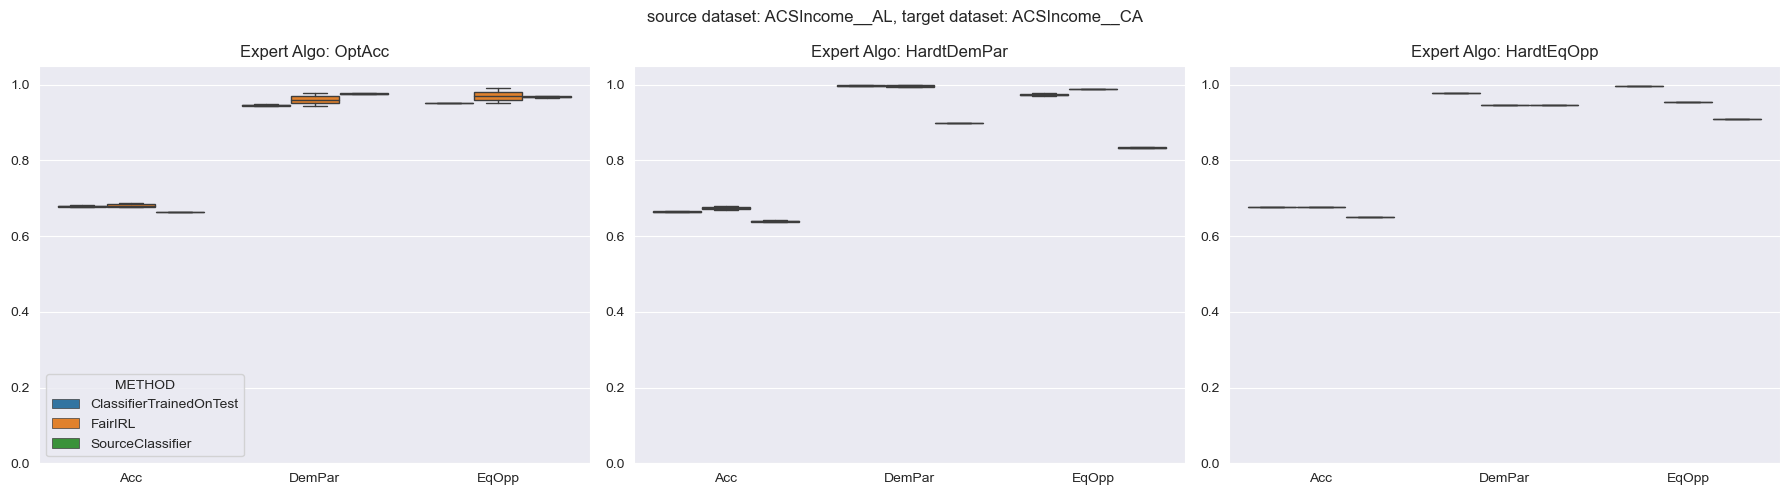

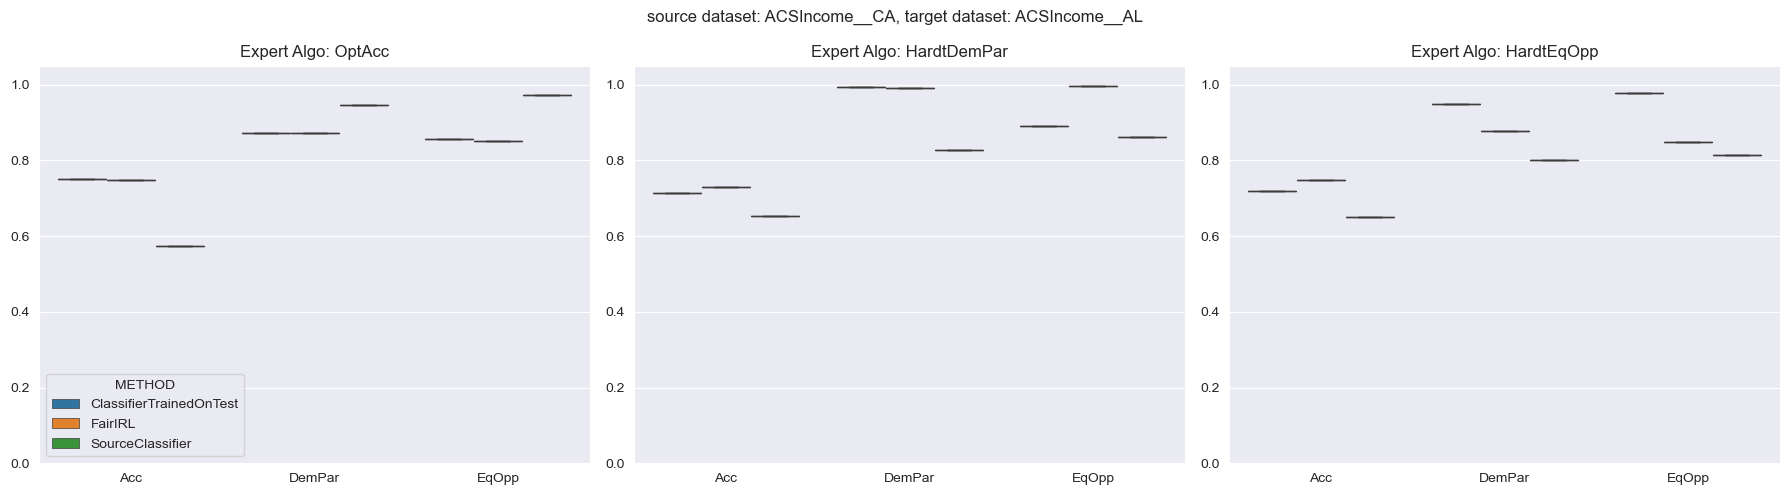

In [33]:
_df = compare(results_df)